In [1]:
from typing import Tuple,Dict,List

In [2]:
import numpy as np; import cvxpy;
from collections import OrderedDict
#crear una lista con los pi de mayor a menor, 
#
def knapsack_fract_greedy(a_weights: np.ndarray, a_values: np.ndarray, bound: int)-> np.ndarray:
    pi_array=a_values/a_weights
    indices_ordenados=np.argsort(pi_array)[::-1]
    capacidad_restante=bound
    mochila={}
    valor_en_mochila=0.
    for i in indices_ordenados:
    #while carga<bound and contador<num_elementos: #esta ultima condición nos ayuda a no salirnos del index del array
        if a_weights[i]<=capacidad_restante:#entra_entero:
            mochila[i]=a_weights[i]
            capacidad_restante -= a_weights[i]
            valor_en_mochila += a_values[i]
        elif capacidad_restante > 0.:
            mochila[i]=capacidad_restante
            capacidad_restante=0.
            valor_en_mochila += a_values[i]*mochila[i]/a_weights[i]
        else: 
            mochila[i]=0
    
    mochila=dict(OrderedDict(sorted(mochila.items())))
    return valor_en_mochila,mochila
        
pesos=np.array([3,1,4,2])
valores=np.array([2,4,4,2])
print(knapsack_fract_greedy(pesos,valores,8))

(10.666666666666666, {0: 1, 1: 1, 2: 4, 3: 2})


In [3]:
import cvxpy as cp ; #import psycipopt
def knapsack_fract_lin_prog(a_weights: np.ndarray, a_values: np.ndarray, bound: float)-> tuple[float, dict]:
    c=a_values #supongo que x es un vector que me dirá cuánto peso cojo para llenar la muchila con el mayor valor
    pi_array=a_values/a_weights
    x = cp.Variable(len(a_weights))
    l_constraint=[x<=a_weights,cp.sum(x)<=bound]
    cost =cp.sum(pi_array @ x)    #c.T @ x
    objetive = cp.Maximize(cost)
    problema= cp.Problem(objetive,l_constraint)
    problema.solve()
    return round(problema.value,4), np.round(x.value,4)

pesos=np.array([1,2,2,4])
valores=np.array([4,4,2,2])
print(knapsack_fract_lin_prog(pesos,valores,5))




(10.0, array([ 1.,  2.,  2., -0.]))


C:\Users\juanj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [4]:
def knapsack_01_pd_matrix(a_weights: np.ndarray, a_values: np.ndarray, bound: int)-> np.ndarray:
    ordenado = sorted(list(zip(a_weights,a_values)))
    
    matriz=np.zeros((len(ordenado),bound+1))
    for fila in range(len(ordenado)):
        for columna in range(bound+1):
            if columna == 0:
                matriz[fila, columna] = 0
            elif fila-1>=0:           #cogemos el [0] porque las tuplas que hay en ordenado tienen como primer elemento son los pesos
                if columna-ordenado[fila][0]>=0: #entramos aqui cuando podamos coger el elemento que este en la fila anterior,en la columna w-wi
                    matriz[fila,columna]=max(ordenado[fila][1]+matriz[fila-1,columna-ordenado[fila][0]], matriz[fila-1,columna])           
                else:
                    matriz[fila,columna]=matriz[fila-1,columna]
            elif columna>=ordenado[fila][0]:  #llegamos aquí cuando estamos en la 1a fila 
                matriz[fila,columna]=ordenado[fila][1] #si el elemento entra,entramos dentro
                
            else: # no entra el elemento
                matriz[fila, columna] = 0
                
    return matriz


pesos=np.array([4, 4, 5])
valores=np.array([10, 11, 15])
pesos2=np.array([4,2,3,5])
valores2=np.array([5,3,4,6])
m = knapsack_01_pd_matrix(pesos, valores, 8)
print(m)
print(sorted(list(zip(pesos,valores))))
        

[[ 0.  0.  0.  0. 10. 10. 10. 10. 10.]
 [ 0.  0.  0.  0. 11. 11. 11. 11. 21.]
 [ 0.  0.  0.  0. 11. 15. 15. 15. 21.]]
[(4, 10), (4, 11), (5, 15)]


In [5]:
pesos=np.array([ 4,5,4])
valores=np.array([11,15,10])   
def knapsack_01_pd(a_weights: np.ndarray, a_values: np.ndarray, bound: int)-> Tuple[int, Dict]:
    tuplas_originales=list(zip(a_weights,a_values)) #con las posiciones originales de la información recibida
    ordenado = sorted(tuplas_originales)
    matriz=knapsack_01_pd_matrix(a_weights,a_values,bound)
    
    num_cols=bound+1
    i=len(a_weights)-1 ; j=bound ;d={}
    last=matriz[i][j] #el valor total que nos llevamos con la solución óptima al problema de la mochila 01
    
    while i>=0:    
        if i==0: #si estamos en la fila con el 1er elemento (fila 0), sabemos que su casilla superior sería cero
            upper=0
        else:
            upper=matriz[i-1][j]
        if last == upper:  #no cogemos ese elemento en la solución óptima
            
            #i-posción del elemento en la tabla original, que puede estar ordenada o no   
            i_pos=tuplas_originales.index(ordenado[i])+1
            d[i_pos]=0
            i -= 1 ; last=matriz[i][j] #nos quedamos con el elemento de arriba
        
        else:
            
            i_pos=tuplas_originales.index(ordenado[i])+1
            d[i_pos]=1
            i -= 1 ; j -= ordenado[i][0] # w-w_i
            last=matriz[i][j]
        
            
    return matriz[-1][-1],dict(sorted(d.items())) #para enseñar el output con los elementos en el orden que se nos han introducido

m=knapsack_01_pd(pesos2,valores2,5)   
print(m)    
         

(7.0, {1: 0, 2: 1, 3: 1, 4: 0})


In [6]:
pesos=np.array([ 4,5,4])
valores=np.array([11,15,10])

def knapsack_01_int_prog(a_weights: np.ndarray, a_values: np.ndarray, bound: int)-> Tuple[int, Dict]:
    
    x = cp.Variable(len(a_weights), boolean=True)
    m_valor= x.T @ a_values #a maximizar
    cost = cp.sum(m_valor)
    m_peso= x.T @ a_weights 
    l_constraint = [cp.sum(m_peso) <= bound]
    objetive = cp.Maximize(cost)
    problema= cp.Problem(objetive,l_constraint)
    valor_opt=problema.solve()
    
    return valor_opt, x.value 
#en comparación con la anterior,en esta función tenemos la ventaja de que no es necesario ordenar los elementos 1ª por su peso y luego por el valor.

knapsack_01_int_prog(pesos,valores,8)   
 
    
    

(21.0, array([1., 0., 1.]))

In [7]:
#db["ejs mongo"].aggregate([{$group:{_id:"$code",count:{$count: {}}},$sort:{count:-1}}, {limit:10}]);
#db["ejs mongo"].aggregate([{$match:{code:"ESP"}},{$group:}])

[69, 55, 47, 31]
99 99
299


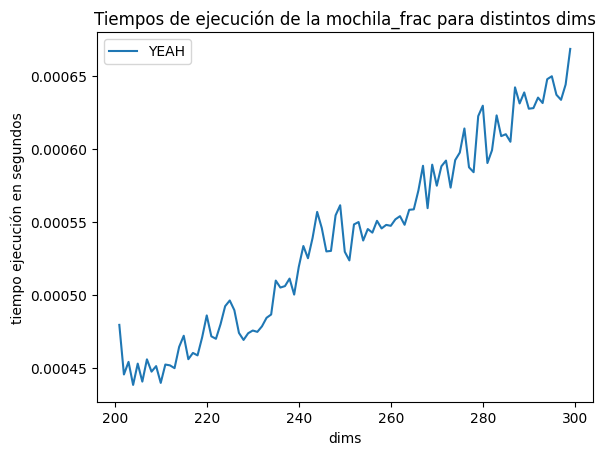

In [66]:
from matplotlib import pyplot as plt ; import time ; import random

bounds = sorted(np.random.randint(10,70,size=4))[::-1]
print(bounds)
first_dim=200
last_dim=300


marcadores = ['o', 's', '^', 'D']
l_timings={}
for bound in bounds:
    a_weights=np.random.randint(1,first_dim+1,size=first_dim)
    a_values=np.random.randint(1,first_dim+1,size=first_dim)
    a_weights=a_weights.tolist() ; a_values=a_values.tolist()
    ejex=[]
    
    
    for dim in range(first_dim,last_dim):
        
        if dim==first_dim: continue
        ejex.append(dim)
        a=np.random.randint(1,dim+1)
        b=np.random.randint(1,dim+1)
        a_values.append(a) ; a_weights.append(b)
        


        #a_values=np.random.randint(1,dim+1,size=dim)
        
        
        timings = %timeit -o -n 10 -r 5 -q knapsack_fract_greedy(np.array(a_weights),np.array(a_values),bound)
            

        try:
            l_timings[dim].append(timings.best)
        except:
            l_timings[dim]=[timings.best]
    
    
    #plt.scatter(ejex,l_timings,marker=marcadores.pop())
    
ejey=[]

for dim in l_timings:
   
    ejey.append(sum(l_timings[dim])/len(l_timings[dim]))
print(len(ejex),len(ejey))    
plt.plot(ejex,ejey,label='')    
plt.legend()
plt.ylabel('tiempo ejecución en segundos')
plt.xlabel('dims')    
plt.title('Tiempos de ejecución de la mochila_frac para distintos dims')    
print(len(a_values))
        



    

In [14]:
l=[0,9]
print(min(l))

0


In [31]:
from matplotlib import pyplot as plt ; import time ; import random
from matplotlib.lines import Line2D

bounds = sorted(np.random.randint(10,100,size=4))
print(bounds)
first_dim=2
last_dim=200

def generador_tuplas(l_tup,times,first_dim,inicio=False): #sin repeticioners
    c=0


    for i in range(times):
        if inicio==False:
            c += 1
        while True:
            a=np.random.randint(1,first_dim+c)
            b=np.random.randint(1,first_dim+c)
            tupla=(a,b)
            if tupla not in l_tup: 
                l_tup
                break

        
marcadores = ['o', 's', '^', 'D']
c=-1
handles=[]
for bound in bounds:
    c += 1
    l_tup = []
    a_weights=np.random.randint(1,first_dim+1,size=first_dim)
    a_values=np.random.randint(1,first_dim+1,size=first_dim)
    a_weights=a_weights.tolist() ; a_values=a_values.tolist()
    ejex=[]
    l_timings=[]
    for dim in range(first_dim,last_dim,10):
        
        if dim==first_dim: continue
        ejex.append(dim)
        a=np.random.randint(1,dim+1)
        b=np.random.randint(1,dim+1)
        a_values.append(a) ; a_weights.append(b)
        


        #a_values=np.random.randint(1,dim+1,size=dim)
        
        try:
            timings = %timeit -o -n 10 -r 5 -q knapsack_01_pd(np.array(a_weights),np.array(a_values),bound)
            
        except:
            for a,b in zip(a_values,a_values):
                print(a,b)
            
            raise Exception
       
        l_timings.append(timings.best)
    plt.plot(ejex,l_timings,label=str(bound))
    
    c=0 ; l_a=[] ; l_b=[]
    for a,b in zip(ejex,l_timings):
        if c==2:
            c=0
            l_a.append(a) ; l_b.append(b)
        else: c += 1
    marcador=marcadores.pop()
    plt.scatter(l_a,l_b,marker=marcador)
    handles.append(Line2D( [c],[0],marker=marcador,label=bound))
plt.legend(handles=handles)





    

[21, 68, 70, 83]
2 2
1 1
7 7
4 4
17 17
35 35
15 15


Exception: 

[37, 56, 75, 80]


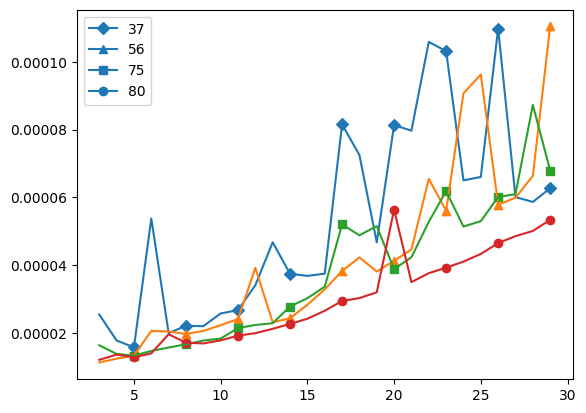

In [20]:
from matplotlib import pyplot as plt ; import time ; import random
from matplotlib.lines import Line2D

bounds = sorted(np.random.randint(10,100,size=4))
print(bounds)
first_dim=2
last_dim=30

def generador_tuplas(l_tup,times,first_dim,inicio=False): #sin repeticioners
    c=0


    for i in range(times):
        if inicio==False:
            c += 1
        while True:
            a=np.random.randint(1,first_dim+c)
            b=np.random.randint(1,first_dim+c)
            tupla=(a,b)
            if tupla not in l_tup: 
                l_tup
                break

        
marcadores = ['o', 's', '^', 'D']
c=-1
handles=[]
for bound in bounds:
    c += 1
    l_tup = []
    a_weights=np.random.randint(1,first_dim+1,size=first_dim)
    a_values=np.random.randint(1,first_dim+1,size=first_dim)
    a_weights=a_weights.tolist() ; a_values=a_values.tolist()
    ejex=[]
    l_timings=[]
    for dim in range(first_dim,last_dim):
        
        if dim==first_dim: continue
        ejex.append(dim)
        a=np.random.randint(1,dim+1)
        b=np.random.randint(1,dim+1)
        a_values.append(a) ; a_weights.append(b)
        


        #a_values=np.random.randint(1,dim+1,size=dim)
        
        try:
            timings = %timeit -o -n 10 -r 5 -q knapsack_fract_greedy(np.array(a_weights),np.array(a_values),bound)
            
        except:
            for a,b in zip(a_values,a_values):
                print(a,b)
            
            raise Exception
       
        l_timings.append(timings.best)
    plt.plot(ejex,l_timings,label=str(bound))
    
    c=0 ; l_a=[] ; l_b=[]
    for a,b in zip(ejex,l_timings):
        if c==2:
            c=0
            l_a.append(a) ; l_b.append(b)
        else: c += 1
    marcador=marcadores.pop()
    plt.scatter(l_a,l_b,marker=marcador)
    handles.append(Line2D( [c],[0],marker=marcador,label=bound))
plt.legend(handles=handles)
